<a href="https://colab.research.google.com/github/alessandromenchetti/COMS6998-Final-Project/blob/main/COMS6998_Final_Project_Concurrent_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

base_folder = "/content/drive/MyDrive/LLM_Project_Data"
base_model_path = f"{base_folder}/llama3.2"
peft_adapters_folder = f"{base_folder}/PEFT_Adapters2"
test_set_path = f"{base_folder}/test_dataset"

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install peft
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install safetensors

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Load the tokenizer and base LLaMA model
tokenizer = AutoTokenizer.from_pretrained(base_model_path)
base_model = AutoModelForCausalLM.from_pretrained(base_model_path, device_map="auto")

# Define paths to LoRA adapters
adapter_paths = {
    "direct": f"{peft_adapters_folder}/direct",
    "evidence": f"{peft_adapters_folder}/evidence",
    "indirect": f"{peft_adapters_folder}/indirect",
    "prediction": f"{peft_adapters_folder}/prediction",
    "risk": f"{peft_adapters_folder}/risk",
}

# Load the LoRA adapters
adapters = {step: PeftModel.from_pretrained(base_model, path, device_map='cuda') for step, path in adapter_paths.items()}

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# CUDA streams for parallel execution
streams = {step: torch.cuda.Stream() for step in ["direct", "evidence", "indirect"]}

# Parallel execution function
def run_parallel_inference(input_ids):
    results = {}
    torch.cuda.synchronize()

    # Launch computations for the first three adapters in separate CUDA streams
    for step in ["direct", "evidence", "indirect"]:
        with torch.cuda.stream(streams[step]):
            results[step] = adapters[step](input_ids).logits

    torch.cuda.synchronize()  # Wait for all streams to finish

    return results

# Sequential execution function for the remaining adapters (as we are just testing difference between sequential pipeline and the one with concurrency actual prompt doesn't matter)
def run_sequential_inference(aggregated_output):
    with torch.no_grad():

        text_input = tokenizer.decode(torch.argmax(results["direct"], dim=-1), skip_special_tokens=True)
        text_input += "\n" + tokenizer.decode(torch.argmax(results["evidence"], dim=-1), skip_special_tokens=True)
        text_input += "\n" + tokenizer.decode(torch.argmax(results["indirect"], dim=-1), skip_special_tokens=True)

        prediction_input = tokenizer(text_input, return_tensors="pt").input_ids.to("cuda")
        prediction_output = adapters["prediction"](prediction_input).logits

        risk_text_input = tokenizer.decode(torch.argmax(prediction_output, dim=-1), skip_special_tokens=True)
        risk_input = tokenizer(risk_text_input, return_tensors="pt").input_ids.to("cuda")
        final_output = adapters["risk"](risk_input).logits

    return final_output

# Full inference pipeline
def inference(input_text):
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

    # Parallel inference for the first three adapters
    aggregated_output = run_parallel_inference(input_ids)

    # Sequential inference for the final two adapters
    final_output = run_sequential_inference(aggregated_output)

    final_prediction_ids = torch.argmax(final_output, dim=-1).flatten().tolist()
    final_prediction = tokenizer.decode(final_prediction_ids, skip_special_tokens=True)
    return final_prediction


# Function for fully sequential pipeline
def inference_full_sequential(input_text):
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

    # Sequentially run all 5 adapters
    current_output = input_ids
    for step in ["direct", "evidence", "indirect", "prediction", "risk"]:
        logits = adapters[step](current_output).logits
        current_output = torch.argmax(logits, dim=-1)

    final_prediction_ids = current_output.flatten().tolist()
    final_prediction = tokenizer.decode(final_prediction_ids, skip_special_tokens=True)
    return final_prediction

In [ ]:
import time

def check_concurrent_inference(input_ids):
    torch.cuda.synchronize()

    start_times = {}

    for step in ["direct", "evidence", "indirect"]:
        torch.cuda.synchronize()

        start_times[step] = time.time()
        with torch.cuda.stream(streams[step]):
            _ = adapters[step](input_ids).logits
        torch.cuda.synchronize()

    torch.cuda.synchronize()

    # Calculate execution time of the first adapter
    direct_execution_time = time.time() - start_times["direct"]

    # Print start times
    for step, start_time in start_times.items():
        print(f"Adapter {step} started at {start_time:.4f} seconds")

    # Validate concurrency: Check if last two adapters started within the execution time of the first
    for step in ["evidence", "indirect"]:
        if start_times[step] - start_times["direct"] <= direct_execution_time:
            print(f"Adapter {step} started within the execution time of the first adapter.")
        else:
            print(f"WARNING: Adapter {step} started outside the execution time of the first adapter.")

    print(f"Execution time of the first adapter (direct): {direct_execution_time:.4f} seconds")


# Example input to profile
example_text = "Example bank customer service transcript."
example_ids = tokenizer(example_text, return_tensors="pt").input_ids.to("cuda")
check_concurrent_inference(example_ids)

Adapter direct started at 1734224667.8309 seconds
Adapter evidence started at 1734224667.8837 seconds
Adapter indirect started at 1734224667.9325 seconds
Adapter evidence started within the execution time of the first adapter.
Adapter indirect started within the execution time of the first adapter.
Execution time of the first adapter (direct): 0.1512 seconds


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import Dataset

def load_test_dataset(test_dataset_path):
    dataset = Dataset.from_file(test_dataset_path)

    # Print one example to verify loading correctly
    print("Sample data point:", dataset[0])
    return dataset


test_set_path = "/content/drive/MyDrive/LLM_Project_Data/test_dataset/data-00000-of-00001.arrow"
test_dataset = load_test_dataset(test_set_path)

Sample data point: {'conversation_id': 'aee2f63e653049769bda7b0c99ad3b90', 'conversation_text': 'agent: Good morning, thank you for calling Union Financial. My name is Helen, how can I assist you today?\nclient: Hi, I\'m Millicent. I was hoping to request some information regarding my account activity. Specifically, I\'d like to know if there have been any large transactions or suspicious activity within the past year.\nagent: Of course, Millicent. I\'d be happy to help you with that. Can you please verify your identity by me by providing your full name, date of birth, and the last four digits of your social security number?\nclient: Sure. My full name is Millicent Smith, my date of birth is February 12th, 1980, and the last four digits of my social security number are 5678.\nagent: Thank you, Millicent. Now, regarding your request for account history, I can certainly provide that information for you. However, I want to let you know that we take the privacy and security of our customer

In [ ]:
def benchmark_inference_comparison(dataset, repetitions=10):
    """
    Benchmark both pipelines and repeat the dataset multiple times to show divergence.
    """
    total_time_concurrent = 0.0
    total_time_sequential = 0.0
    predictions_concurrent = []
    predictions_sequential = []
    times_concurrent = []
    times_sequential = []

    # Extend the dataset by repeating its indices
    extended_indices = list(range(len(dataset))) * repetitions
    extended_dataset = dataset.select(extended_indices)
    print(f"Running benchmarking with {repetitions} repetitions ({len(extended_dataset)} total samples)...")

    print("Benchmarking Concurrent Pipeline...")
    for i, sample in enumerate(extended_dataset):
        start_time = time.time()
        prediction = inference(sample["conversation_text"].strip())
        end_time = time.time()

        predictions_concurrent.append(prediction)
        time_taken = end_time - start_time
        times_concurrent.append(time_taken)
        total_time_concurrent += time_taken

        if (i + 1) % 50 == 0 or (i + 1) == len(extended_dataset):
            print(f"Sample {i + 1}/{len(extended_dataset)} (Concurrent): {time_taken:.2f}s")

    print("\nBenchmarking Fully Sequential Pipeline...")
    for i, sample in enumerate(extended_dataset):
        start_time = time.time()
        prediction = inference_full_sequential(sample["conversation_text"].strip())
        end_time = time.time()

        predictions_sequential.append(prediction)
        time_taken = end_time - start_time
        times_sequential.append(time_taken)
        total_time_sequential += time_taken

        if (i + 1) % 50 == 0 or (i + 1) == len(extended_dataset):
            print(f"Sample {i + 1}/{len(extended_dataset)} (Sequential): {time_taken:.2f}s")

    avg_time_concurrent = total_time_concurrent / len(extended_dataset)
    avg_time_sequential = total_time_sequential / len(extended_dataset)

    print(f"\nAverage Inference Time (Concurrent): {avg_time_concurrent:.2f}s")
    print(f"Average Inference Time (Sequential): {avg_time_sequential:.2f}s")

    return (predictions_concurrent, predictions_sequential,
            times_concurrent, times_sequential)


repetitions = 10
predictions_concurrent, predictions_sequential, times_concurrent, times_sequential = benchmark_inference_comparison(test_dataset, repetitions=repetitions)

Running benchmarking with 10 repetitions (1000 total samples)...
Benchmarking Concurrent Pipeline...
Sample 50/1000 (Concurrent): 0.85s
Sample 100/1000 (Concurrent): 1.14s
Sample 150/1000 (Concurrent): 0.85s
Sample 200/1000 (Concurrent): 1.14s
Sample 250/1000 (Concurrent): 0.85s
Sample 300/1000 (Concurrent): 1.14s
Sample 350/1000 (Concurrent): 0.85s
Sample 400/1000 (Concurrent): 1.14s
Sample 450/1000 (Concurrent): 0.85s
Sample 500/1000 (Concurrent): 1.13s
Sample 550/1000 (Concurrent): 0.85s
Sample 600/1000 (Concurrent): 1.14s
Sample 650/1000 (Concurrent): 0.86s
Sample 700/1000 (Concurrent): 1.13s
Sample 750/1000 (Concurrent): 0.85s
Sample 800/1000 (Concurrent): 1.14s
Sample 850/1000 (Concurrent): 0.85s
Sample 900/1000 (Concurrent): 1.14s
Sample 950/1000 (Concurrent): 0.86s
Sample 1000/1000 (Concurrent): 1.14s

Benchmarking Fully Sequential Pipeline...
Sample 50/1000 (Sequential): 0.88s
Sample 100/1000 (Sequential): 1.13s
Sample 150/1000 (Sequential): 0.88s
Sample 200/1000 (Sequential):

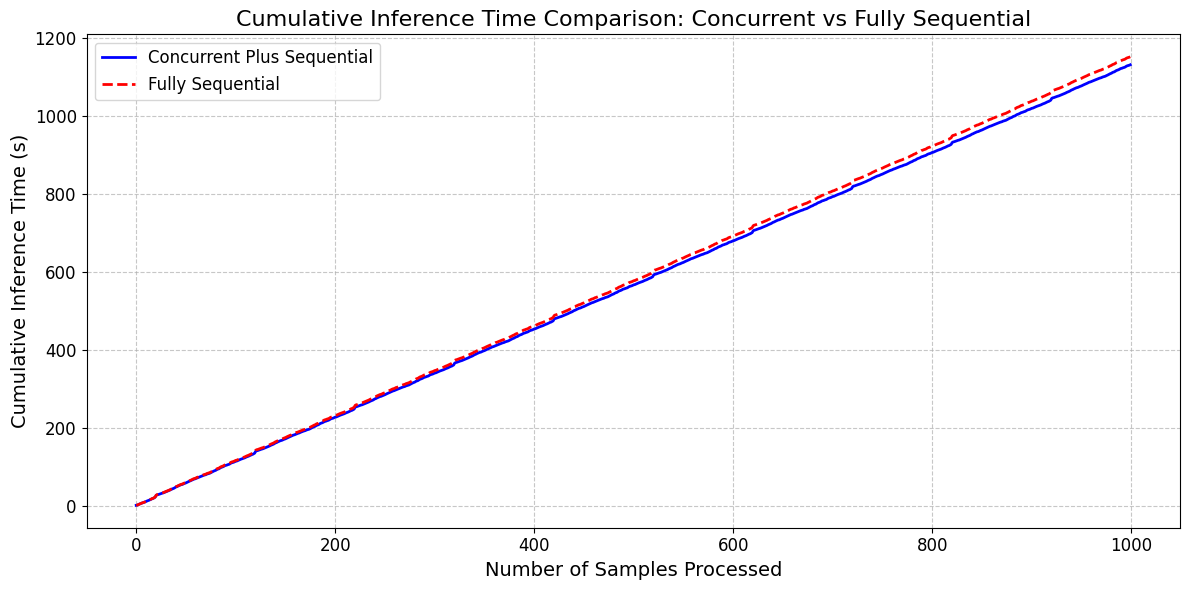

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute cumulative run times
cumulative_times_concurrent = np.cumsum(times_concurrent)
cumulative_times_sequential = np.cumsum(times_sequential)

# Plot culmulative run time vs number of samples processed
plt.figure(figsize=(12, 6))
plt.plot(cumulative_times_concurrent, label="Concurrent Plus Sequential", color="blue", linewidth=2, linestyle='-')
plt.plot(cumulative_times_sequential, label="Fully Sequential", color="red", linewidth=2, linestyle='--')
plt.xlabel("Number of Samples Processed", fontsize=14)
plt.ylabel("Cumulative Inference Time (s)", fontsize=14)
plt.title("Cumulative Inference Time Comparison: Concurrent vs Fully Sequential", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

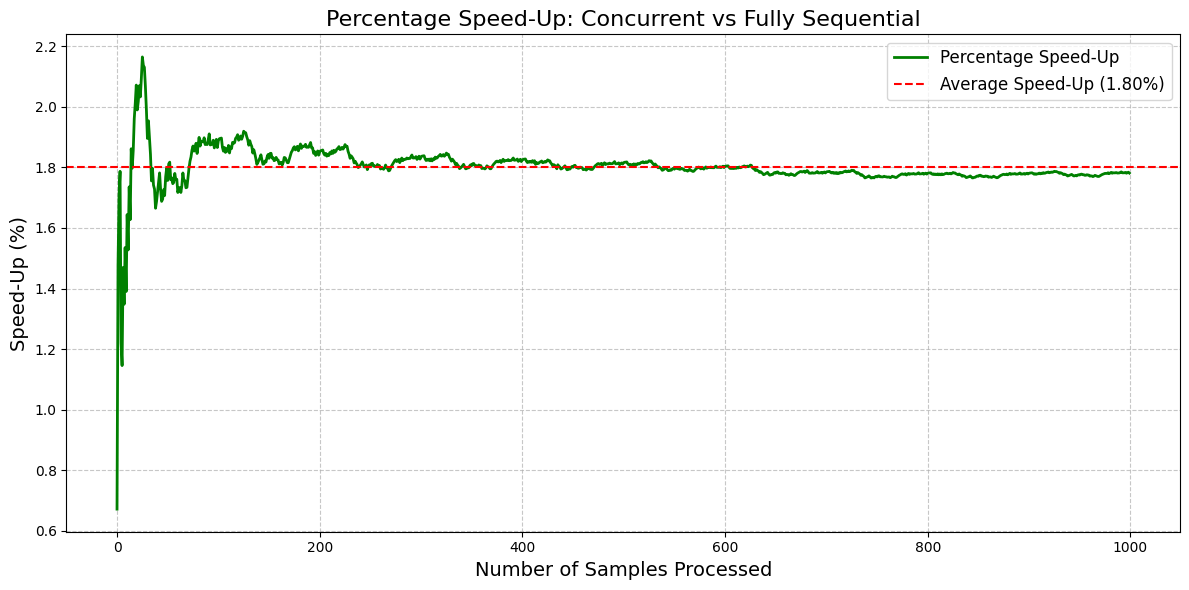

In [ ]:
# Plot percentage speed up vs number of samples processed
speedup_percentage = 100 * (1 - cumulative_times_concurrent / cumulative_times_sequential)
plt.figure(figsize=(12, 6))
plt.plot(speedup_percentage, label="Percentage Speed-Up", color="green", linewidth=2)
avg_speedup = np.mean(speedup_percentage)
plt.axhline(y=avg_speedup, color="red", linestyle="--", label=f"Average Speed-Up ({avg_speedup:.2f}%)")
plt.xlabel("Number of Samples Processed", fontsize=14)
plt.ylabel("Speed-Up (%)", fontsize=14)
plt.title("Percentage Speed-Up: Concurrent vs Fully Sequential", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()